In [64]:
from __init__ import PRP; import sys
sys.path.append(PRP + 'veros/')

from datetime import datetime
from jax import config
config.update("jax_enable_x64", True)

import jax
sys.path.append(PRP)

from scripts.load_runtime import * #Setup parameters for veros 
from setups.acc.acc_learning import ACCSetup


import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'

import jax.numpy as jnp
import pandas as pd
import einops

from typing import Sequence
from flax import linen as nn
from functools import partial
from tqdm.auto import tqdm, trange


In [119]:
from veros import KernelOutput, veros_routine
from jax.tree_util import tree_map

# Spin-Up

In [90]:
# Spin-up 
warmup_steps = 200
acc = ACCSetup()
acc.setup()


def ps(state, sim) : 
    print('Compile')
    n_state = state.copy()
    sim.step(n_state)
    return n_state
    
step_jit = jax.jit(partial(ps, sim=acc))

state = acc.state.copy()
for step in tqdm(range(warmup_steps)) :
    state = step_jit(state)
initial_state = state.copy()

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075


  0%|                                                                                         | 0/200 [00:00<?, ?it/s]

Compile


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.99it/s]


# Correction network 

In [3]:
class Backbone(nn.Module) : 
    
    @nn.compact
    def __call__(self, x) : 
        channels = x.shape[-1]
        x =  nn.Dense(channels)(x) 
        return x
        
class CorrectionModule(nn.Module):
    variables_names: Sequence[str]

    @nn.compact
    def __call__(self, state):
        # Submodule
        backbone = Backbone()

        # 1) Extract the variables we want to correct
        vars_to_correct = [getattr(state.variables, name) for name in self.variables_names]

        # 2) Pack into one big array on the last axis
        flat, ps = einops.pack(vars_to_correct, 'i j *')  # flat: (i, j, C_total)

        # 3) Apply NN (same shape in, same shape out)
        flat_corr = backbone(flat)  # (i, j, C_total)

        # 4) Unpack back to original shapes
        corr_list = einops.unpack(flat_corr, ps, 'i j *')

        # 5) Return a dict mapping variable name -> correction array
        corrections = {name: corr for name, corr in zip(self.variables_names, corr_list)}
        return corrections

def apply_corrections(state, params, correction_model):
    # 1) Get correction fields from the Flax module
    corrections = KernelOutput(**correction_model.apply(params, state))
    # corrections: dict[name -> array] with same shapes as the original vars

    # 2) Write them into a new state
    new_state = state.copy()
    with new_state.variables.unlock():
        new_state.variables.update(corrections)
        
    return new_state

In [4]:
cm = CorrectionModule(['temp', 'salt'])

In [5]:
rng = jax.random.PRNGKey(0)
params = cm.init(rng, initial_state)

In [8]:
new_state = apply_corrections(initial_state, params, cm)

# Correct veros step + gradients

In [9]:
psj = jax.checkpoint(step_jit)

In [10]:
def agg_sum(state, key_sum = 'temp') :
    tau = getattr(state.variables, 'tau')
    return ((getattr(state.variables, key_sum))**2).sum()

def loss_fn_corrected(state, params, ps_fun, agg_fun, correction_model, n_iter=5) : 
    for i in range(n_iter) :
        state = ps_fun(state)
        state = apply_corrections(state, params, correction_model)
    return agg_fun(state)

In [11]:
loss_and_grad_theta = jax.value_and_grad(loss_fn_corrected, argnums=1)

In [13]:
%%time
loss, grad = loss_and_grad_theta(initial_state, params, psj, agg_sum, cm, n_iter=2)

CPU times: user 122 ms, sys: 37.9 ms, total: 160 ms
Wall time: 61.9 ms


## Overfit a correction

1. Create a target state
2. Disable `tke` in veros
3. Learn correction to "emulate" vertical velocity

## Create target and model without TKE

In [228]:
n_rollout = 2
target_state = initial_state.copy()
for step in tqdm(range(n_rollout)) :
    target_state = step_jit(target_state)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 332.12it/s]


In [229]:
class ACC_notke(ACCSetup) : 
    @veros_routine
    def set_parameter(self, state) : 
        super().set_parameter(state)
        settings = state.settings
        settings.enable_tke = False

acc_notke = ACC_notke()
acc_notke.setup()
learning_state = acc_notke.state.copy()
step_jit_notke = jax.jit(partial(ps, sim=acc_notke))


# Initialise with initial variables
with learning_state.variables.unlock() :
    learning_state._variables = tree_map(lambda x : x.copy(), initial_state.variables)

step_jit_notke(learning_state);

Running model setup
Diffusion grid factor delta_iso1 = 0.01942284820457075
Compile


In [230]:
predicted_before_training = learning_state.copy()
for step in tqdm(range(n_rollout)) :
    predicted_before_training = step_jit_notke(predicted_before_training)
predicted_before_training = predicted_before_training.copy()

  0%|                                                                                           | 0/2 [00:00<?, ?it/s]

Compile


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


In [231]:
def get_current_variable(state, key) : 
    tau = getattr(state.variables, 'tau')
    var = getattr(state.variables, key)[..., tau]
    return var
    
def agg_compare(pred_state, target_state, key_sum = 'temp') :
    var_pred = get_current_variable(pred_state, key_sum)
    var_target = get_current_variable(target_state, key_sum)
    return ((var_pred - var_target)**2).mean()

In [232]:
print(f'{target_state.settings.enable_tke=} /  {predicted_state.settings.enable_tke=}')
agg_compare(predicted_before_training, target_state)

target_state.settings.enable_tke=True /  predicted_state.settings.enable_tke=False


Array(0.00020299, dtype=float64)

## Train the model with target state

In [233]:
import optax
tx = optax.adam(learning_rate=0.001)
params = cm.init(rng, learning_state)
opt_state = tx.init(params)

In [234]:
psj = jax.checkpoint(step_jit_notke)

In [235]:
loss_vals = []
for i in trange(200):
  loss_val, grads = loss_and_grad_theta(learning_state, params, psj, partial(agg_compare, target_state=target_state), cm, n_iter=2)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  loss_vals.append(loss_val)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.51it/s]


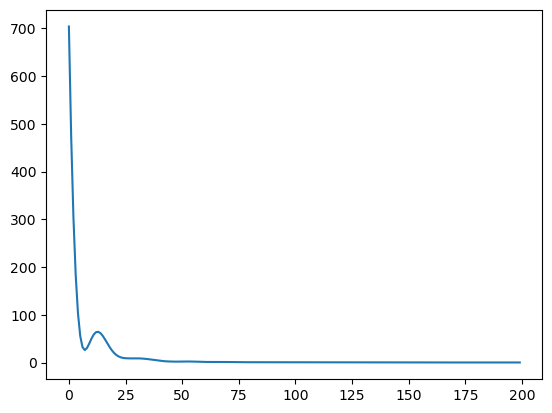

In [236]:
plt.plot(loss_vals)

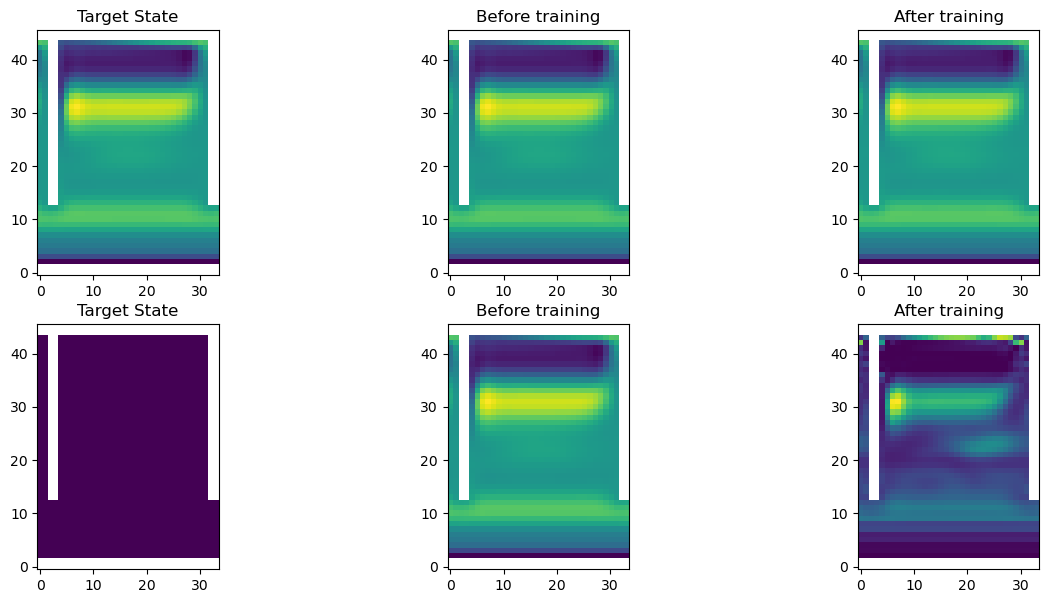

In [237]:
fig, axs = plt.subplots(2,3, figsize=(15,7))


axs[0, 0].set_title('Target State')
axs[0, 0].imshow(get_current_variable(target_state, 'temp').at[mask].set(jnp.nan)[..., 0].T)

axs[0, 1].set_title('Before training')
axs[0, 1].imshow(get_current_variable(predicted_before_training, 'temp').at[mask].set(jnp.nan)[..., 0].T)

axs[0, 2].set_title('After training')
axs[0, 2].imshow(get_current_variable(learning_state, 'temp').at[mask].set(jnp.nan)[..., 0].T)

target = get_current_variable(target_state, 'temp').at[mask].set(jnp.nan)[..., 0]
axs[1, 0].set_title('Target State')
axs[1, 0].imshow(((target - get_current_variable(target_state, 'temp').at[mask].set(jnp.nan)[..., 0])**2).T)

axs[1, 1].set_title('Before training')
axs[1, 1].imshow(((target - get_current_variable(predicted_before_training, 'temp').at[mask].set(jnp.nan)[..., 0])**2).T)


axs[1, 2].set_title('After training')
axs[1, 2].imshow(((target - get_current_variable(learning_state, 'temp').at[mask].set(jnp.nan)[..., 0])**2).T)